# **Import Libraries**

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import yfinance as yf
import matplotlib.pyplot as plt
# !pip install ta
import ta
import pandas as pd

# **Load Data**

In [ ]:
start_date = '2020-09-01'
end_date = '2025-09-01'

df = yf.download('JNJ', start = start_date, end = end_date, auto_adjust = True) # auto_adjust = True is used to adjust the prices for splits and dividends
df.head()



[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,JNJ,JNJ,JNJ,JNJ,JNJ
Date,,,,,
2020-09-01,131.378815,133.598518,130.121562,133.416427,6307700
2020-09-02,133.381744,133.815281,129.410551,130.745837,6881900
2020-09-03,129.670654,134.803720,128.586814,134.248795,8672800
2020-09-04,128.838287,130.884579,127.572369,130.208263,7200100
2020-09-08,127.685036,130.832512,127.372889,130.277586,8756800


In [ ]:
df.reset_index(inplace=True)
df.columns = ['date', 'close', 'high', 'low', 'open', 'volume']
df.columns = [col.strip().lower() for col in df.columns]


In [ ]:
df.head()

,date,close,high,low,open,volume
0,2020-09-01,131.378815,133.598518,130.121562,133.416427,6307700
1,2020-09-02,133.381744,133.815281,129.410551,130.745837,6881900
2,2020-09-03,129.670654,134.803720,128.586814,134.248795,8672800
3,2020-09-04,128.838287,130.884579,127.572369,130.208263,7200100
4,2020-09-08,127.685036,130.832512,127.372889,130.277586,8756800


In [ ]:
df.isnull().sum()

,0
date,0
close,0
high,0
low,0
open,0
volume,0


# **Feature Engineering**

In [ ]:
#ncalculate the returns for the AAPL stock
df['returns']= df['close'].pct_change()
df['aapl_log_returns'] = np.log(1 + df['returns'])

df.dropna(inplace=True)

aapl_df = df.copy()

aapl_df.drop(columns=['open', 'high', 'low','returns'], inplace=True)

aapl_df.head()

,date,close,volume,aapl_log_returns
1,2020-09-02,133.381744,6881900,0.015130
2,2020-09-03,129.670654,8672800,-0.028217
3,2020-09-04,128.838287,7200100,-0.006440
4,2020-09-08,127.685036,8756800,-0.008991
5,2020-09-09,129.800735,6960700,0.016434


In [ ]:
# calculate the volatility of the returns over the last 5 days
aapl_df["volatility_5d"] = aapl_df['aapl_log_returns'].rolling(5).std()
# calculate the momentum of the price over the last 5 days
aapl_df["momentum"] = aapl_df["close"].pct_change(5)
aapl_df["momentum_5d"] = np.log(1 + aapl_df["momentum"])
# calculate the RSI of the price over the last 14 days
aapl_df["rsi_14"] = ta.momentum.RSIIndicator(aapl_df["close"], window=14).rsi()

# calculate the MACD of the price over the last 14 days and calculate EMAs (12, 26, 9 by default)
macd = ta.trend.MACD(aapl_df["close"])

aapl_df["macd"] = macd.macd()
aapl_df["macd_signal"] = macd.macd_signal()
aapl_df["macd_diff"] = macd.macd_diff()




In [ ]:
# Seasonal features

aapl_df["day_of_week"] = aapl_df['date'].dt.dayofweek
aapl_df["month"] = aapl_df['date'].dt.month
aapl_df["quarter"] = aapl_df['date'].dt.quarter


In [ ]:
# add SP500 and VIX returns to the dataframe
add_df = yf.download(tickers = ["^GSPC","^VIX"], start = start_date, end = end_date, auto_adjust = True)
# calculate the percentage change of the Close column
vol_col = add_df['Close'].pct_change()

vol_col.reset_index(inplace=True)
# rename the columns
vol_col.columns = ['date', 'sp500_return', 'vix_return']
# calculate the log of the returns
vol_col['log_sp500_return'] = np.log(1 + vol_col['sp500_return'])
vol_col['log_vix_return'] = np.log(1 + vol_col['vix_return'])

# merge the dataframe with the SP500 and VIX returns
aapl_df = pd.merge(aapl_df, vol_col, on = 'date', how = 'left')
aapl_df.head()

[*********************100%***********************]  2 of 2 completed


,date,close,volume,aapl_log_returns,volatility_5d,momentum,momentum_5d,rsi_14,macd,macd_signal,macd_diff,day_of_week,month,quarter,sp500_return,vix_return,log_sp500_return,log_vix_return
0,2020-09-02,133.381744,6881900,0.015130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,9,3,0.015366,0.017228,0.015249,0.017081
1,2020-09-03,129.670654,8672800,-0.028217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,9,3,-0.035126,0.264584,-0.035758,0.234743
2,2020-09-04,128.838287,7200100,-0.006440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,9,3,-0.008133,-0.084821,-0.008166,-0.088636
3,2020-09-08,127.685036,8756800,-0.008991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,9,3,-0.027756,0.023089,-0.028149,0.022827
4,2020-09-09,129.800735,6960700,0.016434,0.01863,NaN,NaN,NaN,NaN,NaN,NaN,2,9,3,0.020145,-0.084234,0.019945,-0.087994


In [ ]:
aapl_df.isnull().sum()


,0
date,0
close,0
volume,0
aapl_log_returns,0
volatility_5d,4
momentum,5
momentum_5d,5
rsi_14,13
macd,25
macd_signal,33


In [ ]:
# last step is to drop the rows with missing values. We justify this within a time series context because missing data comes from the calculation of technical indicators.

aapl_df.dropna(inplace=True)
aapl_df.drop(columns=['momentum','sp500_return','vix_return'], inplace=True)
aapl_df.reset_index(inplace=True)
aapl_df.drop(columns=['index'], inplace=True)
aapl_df.head()

,date,close,volume,aapl_log_returns,volatility_5d,momentum_5d,rsi_14,macd,macd_signal,macd_diff,day_of_week,month,quarter,log_sp500_return,log_vix_return
0,2020-10-20,125.335289,5325400,0.001592,0.012396,-0.026016,40.227981,-0.623213,-0.377693,-0.245520,1,10,4,0.004716,0.005809
1,2020-10-21,124.797668,5221300,-0.004299,0.012271,-0.028561,38.842352,-0.801429,-0.462440,-0.338989,2,10,4,-0.002198,-0.024139
2,2020-10-22,125.794861,5279700,0.007959,0.013685,-0.014439,42.779301,-0.852376,-0.540428,-0.311949,3,10,4,0.005205,-0.019028
3,2020-10-23,125.933571,4154400,0.001102,0.013019,-0.019500,43.325823,-0.871513,-0.606645,-0.264868,4,10,4,0.003440,-0.020123
4,2020-10-26,124.832382,6929500,-0.008783,0.006355,-0.002429,40.055049,-0.964419,-0.678199,-0.286219,0,10,4,-0.018764,0.164006


# **Normalizing features**

In [ ]:

# categorical feature encoding


# instead of one hot encoding we will be using cyclical encoding as this is better for temporal data
# for more info: https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba/

# day sin and cos
aapl_df['day_sin'] = np.sin(2 * np.pi * aapl_df['day_of_week'] / 7)
aapl_df['day_cos'] = np.cos(2 * np.pi * aapl_df['day_of_week'] / 7)
# month sin and cos
aapl_df['month_sin'] = np.sin(2 * np.pi * aapl_df['month'] / 12)
aapl_df['month_cos'] = np.cos(2 * np.pi * aapl_df['month'] / 12)
# quarter sin and cos
aapl_df['quarter_sin'] = np.sin(2 * np.pi * aapl_df['quarter'] / 4)
aapl_df['quarter_cos'] = np.cos(2 * np.pi * aapl_df['quarter'] / 4)

# drop the original categorical columns and date, close
input_df = aapl_df.copy()

target_features = pd.DataFrame(input_df['aapl_log_returns'])

input_df.drop(columns=['day_of_week', 'month', 'quarter','date','close'], inplace=True)

target_features.head()






,aapl_log_returns
0,0.001592
1,-0.004299
2,0.007959
3,0.001102
4,-0.008783


In [ ]:
#train/test split
train_length = int(0.9 * len(aapl_df))

x_train = input_df[:train_length]
x_test = input_df[train_length:]

# We define y_test and y_train later since the appl_log_returns is in the quantitative_cols which we need to process as sequences within the x_train and x_test

# now we normalize the quantitative features only
quantitative_cols = [ 'aapl_log_returns', 'volume', 'volatility_5d', 'momentum_5d', 'rsi_14',
                'macd', 'macd_signal', 'macd_diff', 'log_sp500_return', 'log_vix_return']

returns_col_name = 'aapl_log_returns'


categorical_cols = ['day_sin', 'day_cos', 'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos']



# Normalize quantitative features
scaler = StandardScaler()


# making sure to fit on the train data and transform on the test data.
#  we also have to define x_train and x_test to be combined with the categorical features,  making sure they are the same shape and as tensors for the model.
# since we added in aapl_log_returns to the quantitative features we can define y_train and y_test later
scaled_x_train_q = scaler.fit_transform(x_train[quantitative_cols])
scaled_x_test_q = scaler.transform(x_test[quantitative_cols])



scaled_x_train = np.concatenate([scaled_x_train_q, x_train[categorical_cols]], axis=1)
scaled_x_test = np.concatenate([scaled_x_test_q, x_test[categorical_cols]], axis=1)

col_names = quantitative_cols + categorical_cols
print(col_names)


['aapl_log_returns', 'volume', 'volatility_5d', 'momentum_5d', 'rsi_14', 'macd', 'macd_signal', 'macd_diff', 'log_sp500_return', 'log_vix_return', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos']


In [ ]:
# # function to split the sequence of returns into lists for input and output for LSTM
# # Jason Brownlee Chapter 9.2 of Deep Learning for time series forecasting code credit


def split_sequence(data, feature_cols, n_steps=5):

    y_returns, X_features = [], []


    # The return column must be first so we know its index (0)
    all_cols =feature_cols


    data_np = data[all_cols].to_numpy()

    # The loop must stop 'n_steps' from the end to ensure there is a target for the last sequence
    for i in range(len(data_np) - n_steps):


        end_of_window = i + n_steps


        input_window = data_np[i:end_of_window, :]
        X_features.append(input_window)

        # The target 'y' is the single return value from the timestep immediately after the window.
        # We get the first column (the return) at that timestep.
        target_value = data_np[end_of_window, 0]
        y_returns.append(target_value)


    return np.array(X_features), np.array(y_returns)

In [ ]:
# we throw this back into a pandas dataframe to for correct object to split into sequences
x_train_df = pd.DataFrame(scaled_x_train, columns=col_names)
x_test_df = pd.DataFrame(scaled_x_test, columns=col_names)

# split into sequences for train and test, y_train and y_test are within the [1] index of the splits
x_train_splits = split_sequence(x_train_df,  col_names, 5)

x_test_splits = split_sequence(x_test_df,  col_names, 5)

x_train = torch.tensor(x_train_splits[0])
x_test = torch.tensor(x_test_splits[0])
y_train = torch.tensor(x_train_splits[1])
y_test = torch.tensor(x_test_splits[1])





In [ ]:
# now we reshape and change the data type
x_train_float = x_train.clone().detach().float()
y_train_float = y_train.clone().detach().float().view(-1, 1)
x_test_float = x_test.clone().detach().float()
y_test_float = y_test.clone().detach().float().view(-1, 1)

# **LSTM Model**

In [ ]:


class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #  LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Final fully-connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # We pass the input and hidden states to the LSTM
        out, _ = self.lstm(x, (h0, c0))

        # We only need the output from the last time step for our prediction
        # out[:, -1, :] selects the last time step's output for every sequence in the batch
        out = self.fc(out[:, -1, :])
        return out

# Set Hyperparameters and Instantiate the Model
# The preprocessed data has 16 features
INPUT_SIZE = 16
HIDDEN_SIZE = 50
NUM_LAYERS = 2    # # of stacked LSTM layers
OUTPUT_SIZE = 1   # We are predicting just log return

model = SimpleLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
# define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for our regression task
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam by default


# DataLoader helps manage memory by processing data in batches.
BATCH_SIZE = 32
train_dataset = TensorDataset(x_train_float, y_train_float)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False) # Shuffle is False for time series




In [ ]:
# start training
NUM_EPOCHS = 50
print("Starting training...")
for epoch in range(NUM_EPOCHS):
    model.train() # Set the model to training mode
    for i, (sequences, labels) in enumerate(train_loader):
        # Forward pass: get the model's predictions
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.6f}')
print("\nTraining finished.")


# Evaluate test set
model.eval()
with torch.no_grad():
    test_predictions = model(x_test_float)
    test_loss = criterion(test_predictions, y_test_float)
    print(f'\nTest MSE Loss: {test_loss.item():.6f}')




Starting training...
Epoch [10/50], Loss: 0.413640
Epoch [20/50], Loss: 0.135976
Epoch [30/50], Loss: 0.093420
Epoch [40/50], Loss: 0.036965
Epoch [50/50], Loss: 0.118165

Training finished.

Test MSE Loss: 1.847054


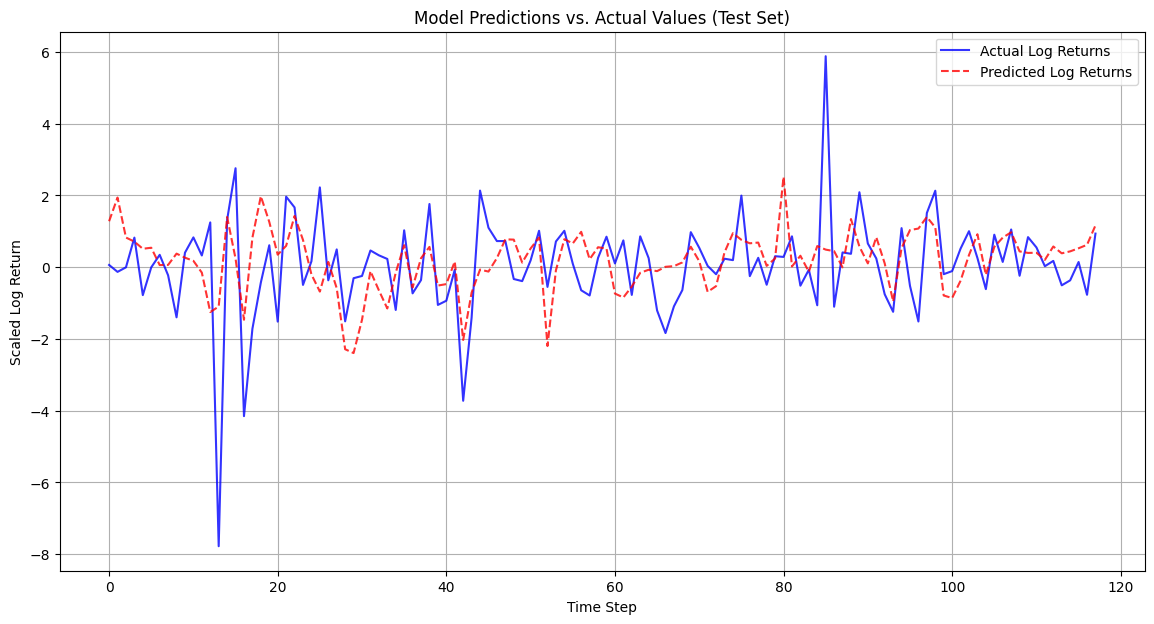

In [ ]:
# plot results
# Convert tensors to numpy arrays for plotting
predicted_values = test_predictions.detach().cpu().numpy()
actual_values = y_test_float.detach().cpu().numpy()

plt.figure(figsize=(14, 7))
plt.plot(actual_values, label='Actual Log Returns', color='blue', alpha=0.8)
plt.plot(predicted_values, label='Predicted Log Returns', color='red', linestyle='--', alpha=0.8)
plt.title('Model Predictions vs. Actual Values (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Scaled Log Return')
plt.legend()
plt.grid(True)
plt.show()